In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score


In [ ]:
# Kết nối Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1. Đọc dữ liệu
train_file_path = "/content/drive/MyDrive/Datasetsmartphone/train.csv"
test_file_path = "/content/drive/MyDrive/Datasetsmartphone/test.csv"

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Kết hợp dữ liệu
data = pd.concat([train_data, test_data]).reset_index(drop=True)

In [ ]:
# 2. Chọn nhiều đặc trưng hơn
selected_features = [
    'tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
    'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
    'tBodyGyro-mean()-X', 'tBodyGyro-mean()-Y', 'tBodyGyro-mean()-Z',
    'tBodyGyro-std()-X', 'tBodyGyro-std()-Y', 'tBodyGyro-std()-Z'
]

X_values = data[selected_features].values


In [ ]:
# 3. Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_values = scaler.fit_transform(X_values)


In [ ]:
# 4. Chuyển đổi nhãn thành số
label_encoder = LabelEncoder()
data['Activity'] = label_encoder.fit_transform(data['Activity'])
y_values = data['Activity'].values


In [ ]:
# 5. Tạo chuỗi dữ liệu time-series
TIME_STEPS = 30

def create_sequences(data, labels=None, time_steps=TIME_STEPS):
    sequences = []
    labels_seq = [] if labels is not None else None
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])
        if labels is not None:
            labels_seq.append(labels[i + time_steps - 1])

    if labels is not None:
        return np.array(sequences), np.array(labels_seq)
    else:
        return np.array(sequences), None

X_seq, y_seq = create_sequences(X_values, y_values)


In [ ]:
# 6. Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)


In [ ]:
# 7. Xây dựng mô hình LSTM
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(32)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(len(label_encoder.classes_), activation='softmax')
])


In [ ]:
# 8. Compile mô hình
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0),
    metrics=['accuracy']
)

In [ ]:
# Khởi tạo input_shape cho mô hình để sử dụng MC Dropout
X_dummy = np.zeros((1, TIME_STEPS, len(selected_features)))  # Tạo dữ liệu giả để gọi mô hình
_ = model.predict(X_dummy)  # Gọi mô hình một lần để tránh lỗi


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [ ]:
# 9. Huấn luyện mô hình
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.6138 - loss: 1.0274 - val_accuracy: 0.7950 - val_loss: 0.5402 - learning_rate: 0.0010
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8748 - loss: 0.3489 - val_accuracy: 0.8647 - val_loss: 0.3418 - learning_rate: 0.0010
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9355 - loss: 0.1967 - val_accuracy: 0.9318 - val_loss: 0.2627 - learning_rate: 0.0010
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9431 - loss: 0.1581 - val_accuracy: 0.9708 - val_loss: 0.0831 - learning_rate: 0.0010
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9636 - loss: 0.1095 - val_accuracy: 0.9075 - val_loss: 0.2631 - learning_rate: 0.0010
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9597 - loss: 0.1240 - val_accuracy: 0.9664 - val_loss: 0.0891 - learning_rate: 0.0010
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9704 - 

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


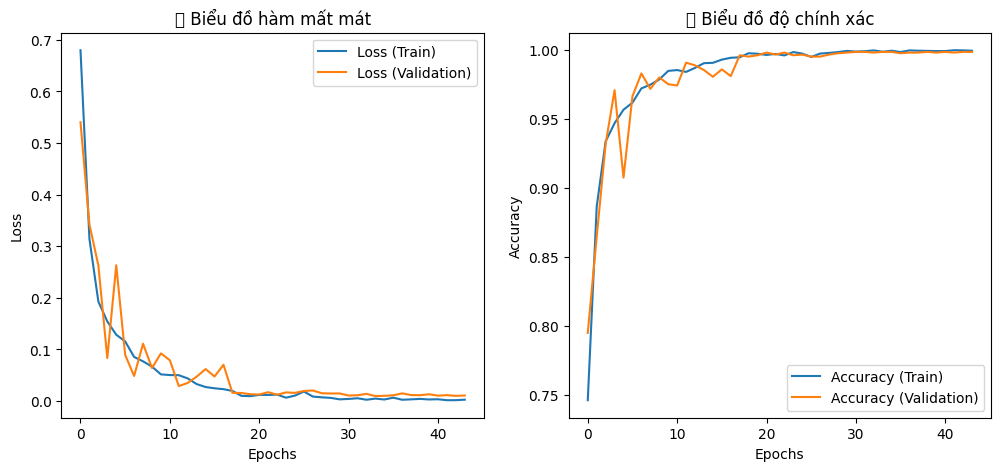

In [ ]:
# Vẽ biểu đồ Accuracy và Loss
plt.figure(figsize=(12, 5))

# 1️⃣ Biểu đồ Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Loss (Train)")
plt.plot(history.history['val_loss'], label="Loss (Validation)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("📉 Biểu đồ hàm mất mát")
plt.legend()

# 2️⃣ Biểu đồ Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Accuracy (Train)")
plt.plot(history.history['val_accuracy'], label="Accuracy (Validation)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("📈 Biểu đồ độ chính xác")
plt.legend()

plt.show()

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

🎯 Độ chính xác trên tập test: 99.85%


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


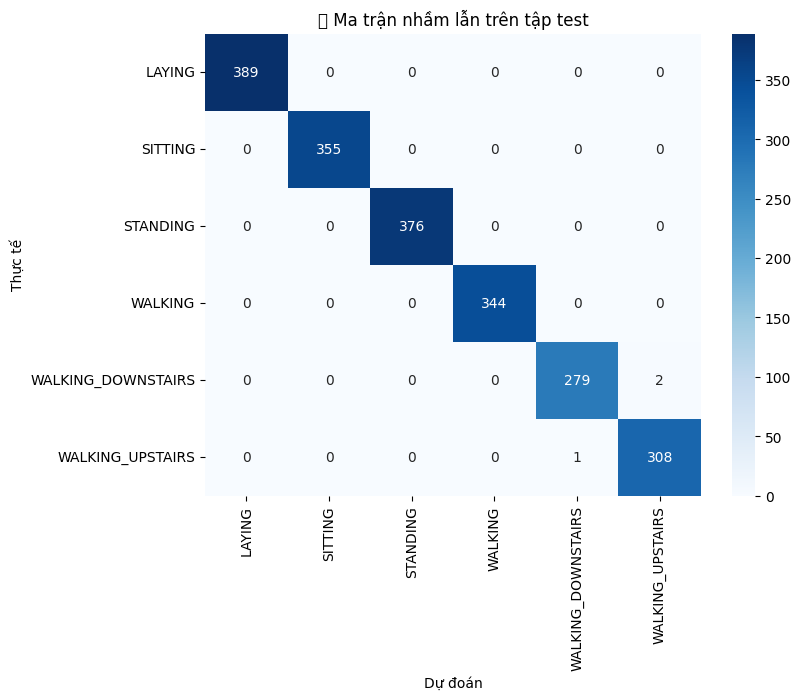

In [ ]:
# 3️⃣ Đánh giá mô hình trên tập test
y_pred = np.argmax(model.predict(X_test), axis=1)
test_accuracy = np.mean(y_pred == y_test)
print(f"\n🎯 Độ chính xác trên tập test: {test_accuracy * 100:.2f}%")
# 🔎 Vẽ ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.title("🔎 Ma trận nhầm lẫn trên tập test")
plt.show()

In [ ]:
#10. Lưu mô hình
model.save("/content/drive/MyDrive/Datasetsmartphone/modelcuatoi.h5")


In [ ]:
# Kiểm tra trên dữ liệu thực tế
# 1. Đọc dữ liệu thực tế
real_data_path = "/content/drive/MyDrive/Datasetsmartphone/dibothucte.csv"
real_data = pd.read_csv(real_data_path)

# 2. Chỉ lấy dữ liệu gia tốc tuyến tính (ax, ay, az)
real_data = real_data[['ax', 'ay', 'az']]
real_data.columns = ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']

# 3. Lọc nhiễu bằng bộ lọc Butterworth
def butter_lowpass_filter(data, cutoff=5, fs=50, order=4):
    nyq = 0.5 * fs  # Tần số Nyquist
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Áp dụng bộ lọc Butterworth
real_data.iloc[:, :3] = real_data.iloc[:, :3].apply(lambda x: butter_lowpass_filter(x), axis=0)

# 4. **Tạo thêm các đặc trưng còn thiếu** để khớp với mô hình
real_data['tBodyAcc-std()-X'] = real_data['tBodyAcc-mean()-X'].rolling(window=10).std()
real_data['tBodyAcc-std()-Y'] = real_data['tBodyAcc-mean()-Y'].rolling(window=10).std()
real_data['tBodyAcc-std()-Z'] = real_data['tBodyAcc-mean()-Z'].rolling(window=10).std()

real_data['tBodyGyro-mean()-X'] = real_data['tBodyAcc-mean()-X'].diff().fillna(0)
real_data['tBodyGyro-mean()-Y'] = real_data['tBodyAcc-mean()-Y'].diff().fillna(0)
real_data['tBodyGyro-mean()-Z'] = real_data['tBodyAcc-mean()-Z'].diff().fillna(0)

real_data['tBodyGyro-std()-X'] = real_data['tBodyGyro-mean()-X'].rolling(window=10).std()
real_data['tBodyGyro-std()-Y'] = real_data['tBodyGyro-mean()-Y'].rolling(window=10).std()
real_data['tBodyGyro-std()-Z'] = real_data['tBodyGyro-mean()-Z'].rolling(window=10).std()

# Điền giá trị thiếu (do rolling mean)
real_data.fillna(method='bfill', inplace=True)

# 5. **Chuẩn hóa dữ liệu bằng StandardScaler đã huấn luyện**
real_X_values = scaler.transform(real_data.values)

# Chuyển dữ liệu chuẩn hóa trở lại DataFrame
real_data = pd.DataFrame(real_X_values, columns=real_data.columns)


<ipython-input-31-9f52c5fbcf6b>:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  real_data.fillna(method='bfill', inplace=True)


In [ ]:
# 6. Chuyển đổi dữ liệu thực tế thành chuỗi time-series
TIME_STEPS = 30  # Số bước thời gian (phù hợp với mô hình đã huấn luyện)

def create_sequences(data, time_steps=TIME_STEPS):
    """
    Chuyển đổi dữ liệu thành chuỗi time-series có độ dài time_steps.
    - data: Dữ liệu đầu vào (DataFrame hoặc numpy array)
    - time_steps: Số bước thời gian cho mỗi chuỗi
    """
    sequences = []
    for i in range(len(data) - time_steps):
        sequences.append(data.iloc[i:i + time_steps].values)  # Tạo chuỗi 30 bước
    return np.array(sequences)

# Chuyển đổi dữ liệu thực tế thành chuỗi time-series
real_X = create_sequences(real_data)
import tensorflow as tf
from tensorflow.keras.models import Model


In [ ]:

# 1. Gọi `model.predict()` một lần để thiết lập mô hình
_ = model.predict(real_X[:1])  # Chạy dự đoán trên 1 mẫu dữ liệu

print("✅ Mô hình đã được gọi thành công, sẵn sàng cho MC Dropout!")

# 2. Hàm MC Dropout
def mc_dropout_prediction(model, X_input, num_samples=10):
    """
    Thực hiện dự đoán nhiều lần với Dropout được bật để lấy độ tin cậy của mô hình.
    - model: Mô hình đã huấn luyện
    - X_input: Dữ liệu đầu vào (chuỗi time-series)
    - num_samples: Số lần lấy mẫu để tính độ chắc chắn
    """
    predict_function = lambda x: model(x, training=True) if isinstance(x, tf.Tensor) else model(tf.convert_to_tensor(x), training=True)  # Mô hình chỉ chứa input/output

    # Dự đoán nhiều lần với Dropout được bật
    predictions = np.array([predict_function(tf.convert_to_tensor(X_input))[0] for _ in range(num_samples)])

    # Lấy giá trị phổ biến nhất làm kết quả cuối cùng
    final_pred = np.argmax(np.mean(predictions, axis=0), axis=-1).reshape(-1) if len(predictions.shape) > 1 else np.array([np.argmax(np.mean(predictions, axis=0))])
    return final_pred

# 3. Thực hiện dự đoán
real_y_pred = mc_dropout_prediction(model, real_X, num_samples=10)

# 4. Giải mã nhãn từ số thành tên hoạt động
predicted_labels = label_encoder.inverse_transform(real_y_pred)

# 5. Hiển thị kết quả
print("📌 Kết quả dự đoán với MC Dropout:")
print(predicted_labels[:10])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
✅ Mô hình đã được gọi thành công, sẵn sàng cho MC Dropout!
📌 Kết quả dự đoán với MC Dropout:
['WALKING_DOWNSTAIRS']


In [ ]:
# Dự đoán trên 10 mẫu ngẫu nhiên từ tập test
random_indices = np.random.choice(len(X_test), 10, replace=False)
test_samples = X_test[random_indices]
test_true_labels = y_test[random_indices]

predictions = model.predict(test_samples)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_true_labels

print("\n📊 Kết quả trên 10 mẫu ngẫu nhiên từ tập test:")
for i, idx in enumerate(random_indices):
    predicted_label = label_encoder.inverse_transform([predicted_classes[i]])[0]
    actual_label = label_encoder.inverse_transform([true_classes[i]])[0]
    print(f"Mẫu {i+1}: Dự đoán: {predicted_label} |  Thực tế: {actual_label}")
# 9. Đánh giá tỷ lệ dự đoán đúng
accuracy = np.mean(predicted_classes == true_classes)
correct_predictions = np.sum(predicted_classes == true_classes)
print(f"✅ Tỷ lệ dự đoán đúng: {accuracy * 100:.2f}% ({correct_predictions}/10 mẫu)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

📊 Kết quả trên 10 mẫu ngẫu nhiên từ tập test:
Mẫu 1: Dự đoán: LAYING |  Thực tế: LAYING
Mẫu 2: Dự đoán: WALKING_DOWNSTAIRS |  Thực tế: WALKING_DOWNSTAIRS
Mẫu 3: Dự đoán: STANDING |  Thực tế: STANDING
Mẫu 4: Dự đoán: LAYING |  Thực tế: LAYING
Mẫu 5: Dự đoán: LAYING |  Thực tế: LAYING
Mẫu 6: Dự đoán: WALKING |  Thực tế: WALKING
Mẫu 7: Dự đoán: SITTING |  Thực tế: SITTING
Mẫu 8: Dự đoán: LAYING |  Thực tế: LAYING
Mẫu 9: Dự đoán: LAYING |  Thực tế: LAYING
Mẫu 10: Dự đoán: WALKING_DOWNSTAIRS |  Thực tế: WALKING_DOWNSTAIRS
✅ Tỷ lệ dự đoán đúng: 100.00% (10/10 mẫu)



📊 Đánh giá mô hình trên tập test:
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
🎯 Độ chính xác trên tập test: 99.85%

📑 Báo cáo phân loại:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       389
           SITTING       1.00      1.00      1.00       355
          STANDING       1.00      1.00      1.00       376
           WALKING       1.00      1.00      1.00       344
WALKING_DOWNSTAIRS       1.00      0.99      1.00       281
  WALKING_UPSTAIRS       0.99      1.00      1.00       309

          accuracy                           1.00      2054
         macro avg       1.00      1.00      1.00      2054
      weighted avg       1.00      1.00      1.00      2054



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128270 (\N{RIGHT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


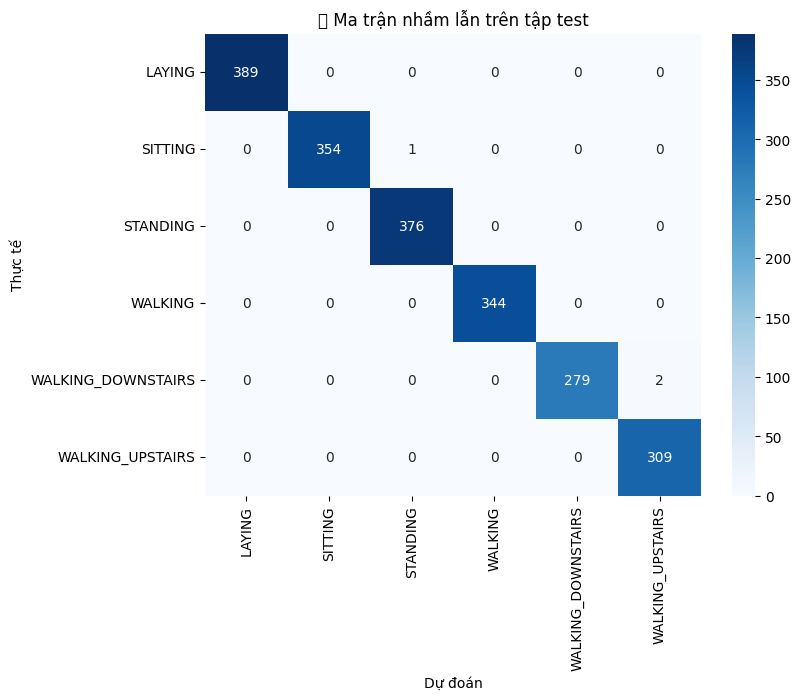

In [ ]:

# 10. Đánh giá trên toàn bộ tập test
print("\n📊 Đánh giá mô hình trên tập test:")
y_pred = np.argmax(model.predict(X_test), axis=1)  # Dự đoán cho toàn bộ tập test

# Tính độ chính xác tổng thể
test_accuracy = np.mean(y_pred == y_test)
print(f"🎯 Độ chính xác trên tập test: {test_accuracy * 100:.2f}%")

# Báo cáo phân loại
print("\n📑 Báo cáo phân loại:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Vẽ ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.title("🔎 Ma trận nhầm lẫn trên tập test")
plt.show()

# 11. Trực quan hóa một số hình ảnh với dự đoán
if X_test.shape[1] == 28 * 28:  # Kiểm tra nếu dữ liệu là ảnh (ví dụ: MNIST 28x28)
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    axes = axes.ravel()

    for i in range(10):
        axes[i].imshow(test_samples[i].reshape(28, 28), cmap="gray")
        axes[i].set_title(f"🚀 Dự đoán: {label_encoder.inverse_transform([predicted_classes[i]])[0]}\n✅ Thực tế: {label_encoder.inverse_transform([true_classes[i]])[0]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()